# Chapter 4 - Classification

In [316]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
from sklearn import datasets
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split




### 10. This question should be answered using the Weekly data set, which is part of the ISLR package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

#### (a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [19]:
weekly = pd.read_csv('Weekly.csv')

assert weekly.isnull().sum().sum() == 0
weekly = pd.get_dummies(weekly).drop(['Direction_Down'],axis=1)

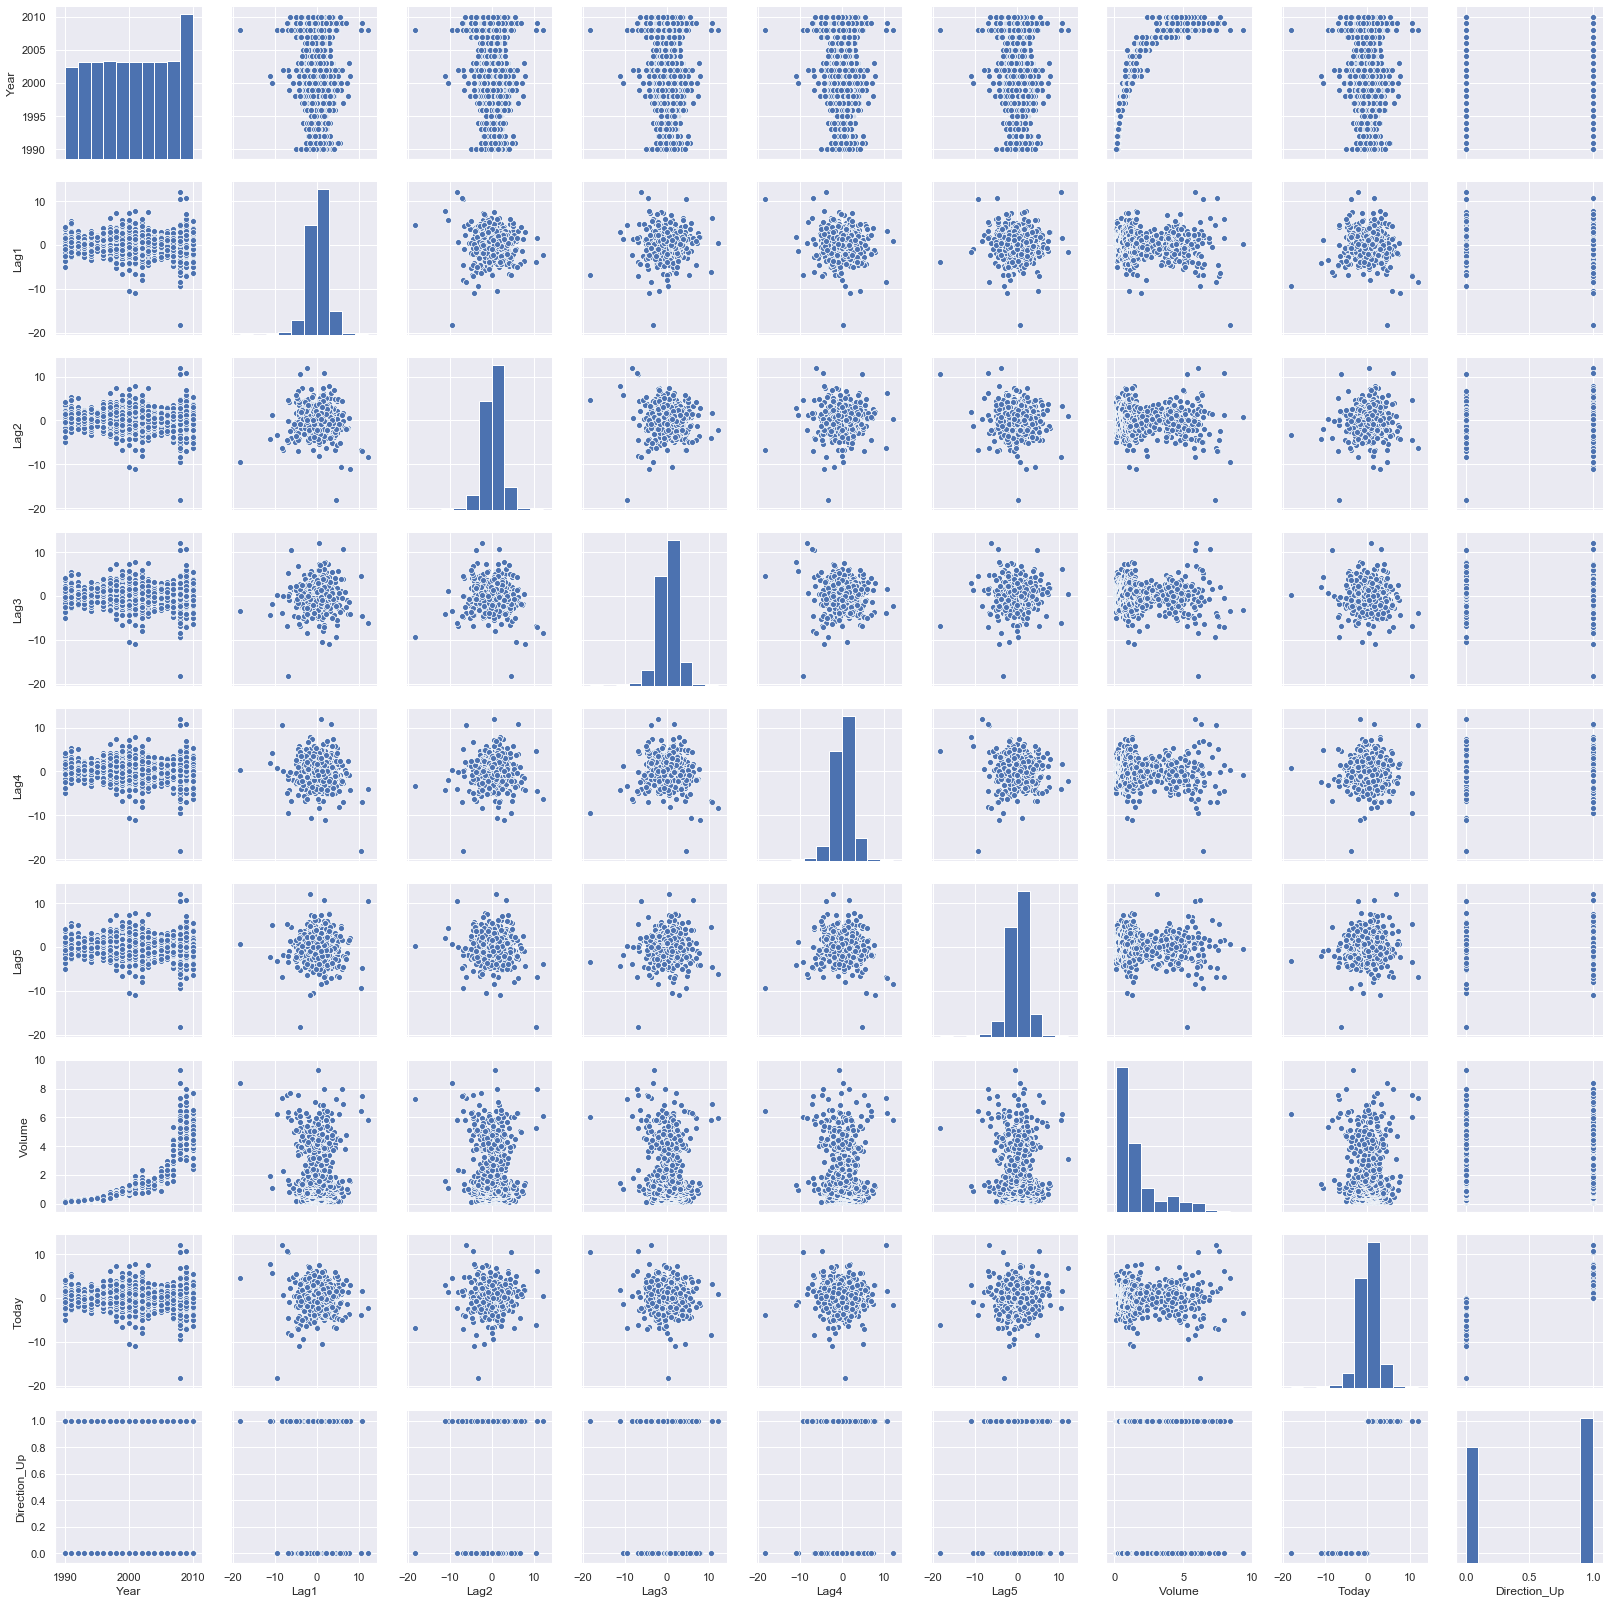

In [21]:
sns.pairplot(weekly)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text yticklabel objects>)

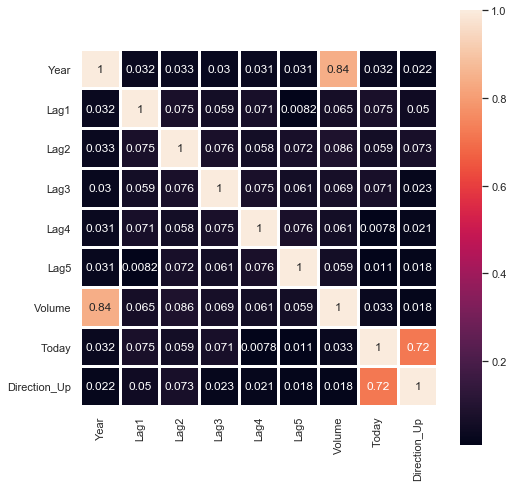

In [37]:
plt.figure(figsize=(8,8))
sns.heatmap(abs(weekly.corr()),square=True,annot=True,linewidths=2, linecolor='white')
plt.yticks(rotation=0)

The correlation matrix above shows that only 2 pairs of features are correlated:

- Year – Volume
- Today – Direction_UP

Looking at the pairplot above suggests:

- Volume increases exponentially with Year
- There is a logistic relationship between Today and Direction_Up

**(b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?**

In [66]:
log = LogisticRegression(random_state=0)
log.fit(weekly.drop(['Year','Today','Direction_Up'],axis=1),weekly['Direction_Up'])
y_pred = log.predict(weekly.drop(['Year','Today','Direction_Up'],axis=1))
print("B0 {}".format(log.intercept_[0]))
for i in range(0,5):
    print ("B" + str(i+1) + " " + str(log.coef_[0][i]))

B0 0.26484744777685393
B1 -0.041172916625222766
B2 0.05846973997174031
B3 -0.015991217649558378
B4 -0.02769997796741264
B5 -0.01440288547117626


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [67]:
#alternative
f = 'Direction_Up ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'

log2 = smf.logit(formula=f,data=weekly).fit()
print(log2.summary())

display(HTML('<h3>Statistically significant predictors:</h3>'))
display(log2.pvalues[log2.pvalues<0.05].sort_values())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           Direction_Up   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 07 May 2020   Pseudo R-squ.:                0.006580
Time:                        00:21:34   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

Intercept    0.001899
Lag2         0.029601
dtype: float64

**(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression**

In [79]:
print(confusion_matrix(weekly['Direction_Up'],y_pred))
print(classification_report(weekly['Direction_Up'],y_pred))
print("TP: {}".format(confusion_matrix(weekly['Direction_Up'],y_pred)[0][0]))
print("FP: {}".format(confusion_matrix(weekly['Direction_Up'],y_pred)[0][1]))
print("FN: {}".format(confusion_matrix(weekly['Direction_Up'],y_pred)[1][0]))
print("TN: {}".format(confusion_matrix(weekly['Direction_Up'],y_pred)[1][1]))
print("Precision: {}".format(55/(55+47)))
print("Recall:{}".format(55/(55+429)))

[[ 55 429]
 [ 47 558]]
              precision    recall  f1-score   support

           0       0.54      0.11      0.19       484
           1       0.57      0.92      0.70       605

    accuracy                           0.56      1089
   macro avg       0.55      0.52      0.44      1089
weighted avg       0.55      0.56      0.47      1089

TP: 55
FP: 429
FN: 47
TN: 558
Precision: 0.5392156862745098
Recall:0.11363636363636363


55.556% of observations are positive

Overall the model got 56.1% of predictions correct. This is marginally better than naively predicting that all observations will yield a return which we would expect to yield 55.6% correct predictions.

92% senstivity tells us that 92% of stocks that actually yield a return were predicted correctly.
Our model is much worse at predicting no dividends (a decrease in stock), this shown by a specificity of only 11% – only 11% of our models predictions for Direction_Up = 0 were correct.

The above translates to a high false positive rate of 89% – 89% of negative results were predicted as positive.
Our model predicts a high proportion of the true positive observations correctly (92% true positive rate), but it also predicts a high proportion of true negative results incorrectly (11% true negative rate).

This model might be more useful for predicting which stocks to invest in if we could reduce the rate of false positive results.

In [81]:
#Data is not imbalanced, this mean that the model does not classify correctly data with Direction Down.
weekly.groupby('Direction_Up').count()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Direction_Up,,,,,,,,
0,484,484,484,484,484,484,484,484
1,605,605,605,605,605,605,605,605


**(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010)**

In [198]:
def positive_observations(y):
    positive = (y==1).sum() / len(y)
    percentage = np.around(positive *100,3)
    print("Positive observations: {}%".format(percentage)) 

def prior_error_rate(confusion_matrix):
    """1 - The prior probability that a result is positive"""
    return 1- np.sum(confusion_matrix[1,:])/np.sum(confusion_matrix)

def total_error_rate(confusion_matrix):
    return 1- np.sum(confusion_matrix.diagonal())/np.sum(confusion_matrix)

def sensitivity(confusion_matrix):
    return confusion_matrix[1,1]/np.sum(confusion_matrix[1,:])

def false_negative_rate(confusion_matrix):
    return 1- sensitivity(confusion_matrix)

def false_positive_rate(confusion_matrix):
    return confusion_matrix[0,1]/np.sum(confusion_matrix[0,:])

def true_negative_rate(confusion_matrix):
    return confusion_matrix[0,0]/np.sum(confusion_matrix[0,:])

def precision(confusion_matrix):
    return confusion_matrix[1,1]/ np.sum(confusion_matrix[:,1])

def negative_predictive_value(confusion_matrix):
    return confusion_matrix[0,0]/np.sum(confusion_matrix[:,0])

def model_stats(confusion_matrix):
    return pd.Series({'Prior error rate': prior_error_rate(confusion_matrix),
                      'total_error_rate': total_error_rate(confusion_matrix),
                      'true_positive_rate':sensitivity(confusion_matrix),
                      'false_negative_rate': false_negative_rate(confusion_matrix),
                      'false_positive_rate':false_positive_rate(confusion_matrix),
                      'true_negative_rate (specificity)':  true_negative_rate(confusion_matrix),
                      'Precision': precision(confusion_matrix),
                      'negative_predictive_value': negative_predictive_value(confusion_matrix)
                     })
    
    

In [200]:
weekly_08 = weekly[weekly['Year']<=2008]
weekly_test = weekly[weekly['Year']>2008]
y_real = weekly[weekly['Year']>2008]['Direction_Up']

f = 'Direction_Up ~ Lag2'
log = smf.logit(formula=f,data=weekly_08).fit()
pred = (log.predict(weekly_test) > 0.5).astype(int)

positive_observations(y_real)

model_stats(confusion_matrix(y_real,pred))

logit = model_stats(confusion_matrix(y_test,y_pred))



Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
Positive observations: 58.654%


**(e) Repeat (d) using LDA.**

In [201]:
X_train = np.array(weekly_08['Lag2']).reshape(-1,1)
X_test = np.array(weekly_test['Lag2']).reshape(-1,1)
y_train = np.array(weekly_08['Direction_Up']).reshape(-1,1)
y_test = np.array(weekly_test['Direction_Up']).reshape(-1,1)

positive_observations(y_test)

lda = LinearDiscriminantAnalysis().fit(X_train,y_train)
y_pred = lda.predict(X_test)

display(model_stats(confusion_matrix(y_test,y_pred)))

lda_stats = model_stats(confusion_matrix(y_test,y_pred))

Positive observations: 58.654%


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Prior error rate                    0.413462
total_error_rate                    0.375000
true_positive_rate                  0.918033
false_negative_rate                 0.081967
false_positive_rate                 0.790698
true_negative_rate (specificity)    0.209302
Precision                           0.622222
negative_predictive_value           0.642857
dtype: float64

**(f) Repeat (d) using QDA.**

In [202]:
X_train = np.array(weekly_08['Lag2']).reshape(-1,1)
X_test = np.array(weekly_test['Lag2']).reshape(-1,1)
y_train = np.array(weekly_08['Direction_Up'])
y_test = np.array(weekly_test['Direction_Up'])

positive_observations(y_test)

qda = QuadraticDiscriminantAnalysis().fit(X_train,y_train)
y_pred = qda.predict(X_test)

display(model_stats(confusion_matrix(y_test,y_pred)))

qda_stats = model_stats(confusion_matrix(y_test,y_pred))

Positive observations: 58.654%


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


Prior error rate                    0.413462
total_error_rate                    0.413462
true_positive_rate                  1.000000
false_negative_rate                 0.000000
false_positive_rate                 1.000000
true_negative_rate (specificity)    0.000000
Precision                           0.586538
negative_predictive_value                NaN
dtype: float64

**(g) Repeat (d) using KNN with K = 1.**

In [209]:
from sklearn.neighbors import KNeighborsClassifier

X_train = np.array(weekly_08['Lag2']).reshape(-1,1)
X_test = np.array(weekly_test['Lag2']).reshape(-1,1)
y_train = np.array(weekly_08['Direction_Up'])
y_test = np.array(weekly_test['Direction_Up'])

KNN = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)
y_pred = KNN.predict(X_test)

display(positive_observations(y_test))
print(classification_report(y_test,y_pred))

kneibours = model_stats(confusion_matrix(y_test,y_pred))

Positive observations: 58.654%


None

              precision    recall  f1-score   support

           0       0.40      0.49      0.44        43
           1       0.58      0.49      0.53        61

    accuracy                           0.49       104
   macro avg       0.49      0.49      0.49       104
weighted avg       0.51      0.49      0.49       104



In [206]:
result = pd.DataFrame({'Logit':logit,'LDA':lda_stats,'QDA':qda_stats,'KNN':kneibours}).T

result.T

,Logit,LDA,QDA,KNN
Prior error rate,0.413462,0.413462,0.413462,0.413462
total_error_rate,0.509615,0.375000,0.413462,0.509615
true_positive_rate,0.491803,0.918033,1.000000,0.491803
false_negative_rate,0.508197,0.081967,0.000000,0.508197
false_positive_rate,0.511628,0.790698,1.000000,0.511628
true_negative_rate (specificity),0.488372,0.209302,0.000000,0.488372
Precision,0.576923,0.622222,0.586538,0.576923
negative_predictive_value,0.403846,0.642857,NaN,0.403846


- Logistic regression and LDA provide the best results in terms of overall error rate. That is, they make the lowest number of incorrect predictions overall. These models produce an total error rate of 37.5% which is better than the naive approach of assuming all results are positive which would yield 41.3% error rate. These models also exhibit the highest precision, that is a higher proportion of positive predictions are correct.

- With a total error rate of 50.9% KNN performs worse than a naive approach overall, but it is superior in terms of specificity. Therefore knn might be prefered if we wanted to minimise false positive predictions.

- In terms of predicting which stocks to invest in, we are most concerned with the precision of our model, e.g. what proportion of stocks we invest in actually return dividends. Therefore LDA or Logistic Regression seem like the best choices.

**(i) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.**

In [273]:
def confusion_table(confusion_mtx):
    """Renders a nice confusion table with labels"""
    confusion_df = pd.DataFrame({'y_pred=0': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=1': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=0', 'y=1', 'Total']}).set_index('')
    return confusion_df

In [274]:
# Create hold-out sets
train_idx       = weekly.index[weekly['Year'] < 2009]
weekly_df_train = weekly.iloc[train_idx]
weekly_df_test  = weekly.drop(train_idx)

predictors  = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Year']
X_train = np.array(weekly_df_train[predictors])
X_test  = np.array(weekly_df_test[predictors])
y_train = np.array(weekly_df_train['Direction_Up'])
y_test  = np.array(weekly_df_test['Direction_Up'])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)
# KNN_1
K = 1
model_knn_1 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
# KNN_3
K = 73
model_knn_73 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
# KNN_10
K = 10
model_knn_10 = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)



model = {'logit':model_logit,
        'LDA':model_lda,
        'QDA':model_qda,
        'KNN1':model_knn_1,
         'KNN10':model_knn_10,
         'KNN73':model_knn_73
        }

scaled = ['knn_1', 'knn_10', 'knn_73']


# PREDICT
for k in model:
    # Predict
    if k in scaled:
        y_pred = model[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = model[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(model_stats(confusion_mtx))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,y_pred=0,y_pred=1,Total
,,,
y=0,31,12,43
y=1,44,17,61
Total,75,29,


Prior error rate                    0.413462
total_error_rate                    0.538462
true_positive_rate                  0.278689
false_negative_rate                 0.721311
false_positive_rate                 0.279070
true_negative_rate (specificity)    0.720930
Precision                           0.586207
negative_predictive_value           0.413333
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,30,13,43
y=1,44,17,61
Total,74,30,


Prior error rate                    0.413462
total_error_rate                    0.548077
true_positive_rate                  0.278689
false_negative_rate                 0.721311
false_positive_rate                 0.302326
true_negative_rate (specificity)    0.697674
Precision                           0.566667
negative_predictive_value           0.405405
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,38,5,43
y=1,50,11,61
Total,88,16,


Prior error rate                    0.413462
total_error_rate                    0.528846
true_positive_rate                  0.180328
false_negative_rate                 0.819672
false_positive_rate                 0.116279
true_negative_rate (specificity)    0.883721
Precision                           0.687500
negative_predictive_value           0.431818
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,28,15,43
y=1,31,30,61
Total,59,45,


Prior error rate                    0.413462
total_error_rate                    0.442308
true_positive_rate                  0.491803
false_negative_rate                 0.508197
false_positive_rate                 0.348837
true_negative_rate (specificity)    0.651163
Precision                           0.666667
negative_predictive_value           0.474576
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,37,6,43
y=1,45,16,61
Total,82,22,


Prior error rate                    0.413462
total_error_rate                    0.490385
true_positive_rate                  0.262295
false_negative_rate                 0.737705
false_positive_rate                 0.139535
true_negative_rate (specificity)    0.860465
Precision                           0.727273
negative_predictive_value           0.451220
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,33,10,43
y=1,40,21,61
Total,73,31,


Prior error rate                    0.413462
total_error_rate                    0.480769
true_positive_rate                  0.344262
false_negative_rate                 0.655738
false_positive_rate                 0.232558
true_negative_rate (specificity)    0.767442
Precision                           0.677419
negative_predictive_value           0.452055
dtype: float64

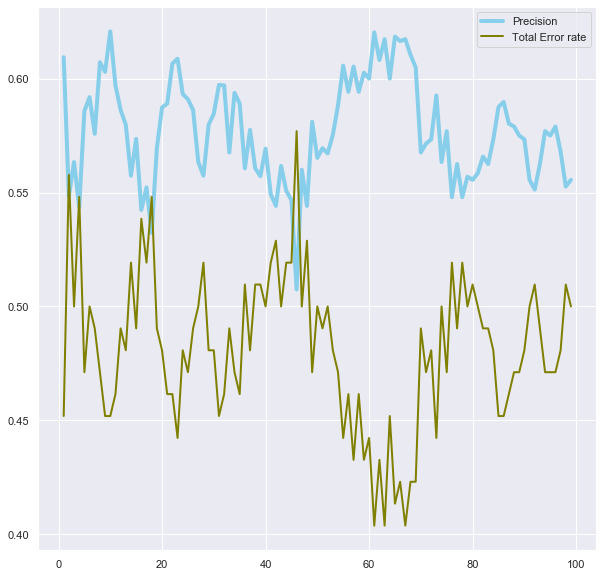

In [279]:
elbow = []
for k in range(1,100):
    KnnK = KNeighborsClassifier(n_neighbors=k).fit(preprocessing.scale(X_train),y_train)
    y_pred = KnnK.predict(preprocessing.scale(X_test))
    
    elbow += [[k,precision(confusion_matrix(y_test,y_pred)),total_error_rate(confusion_matrix(y_test,y_pred))]]

df = pd.DataFrame({'K': np.array(elbow)[:,0],'Precision':np.array(elbow)[:,1],'Total Error rate': np.array(elbow)[:,2] })
plt.figure(figsize=(10,10))

plt.plot( 'K', 'Precision', data=df,  color='skyblue', linewidth=4)
plt.plot( 'K', 'Total Error rate', data=df, marker='', color='olive', linewidth=2)
plt.legend()

In [250]:
df[df.Precision == df.Precision.max()]

,K,Precision,Total Error rate
72,73.0,0.64557,0.365385


In [252]:
df[df['Total Error rate'] == df["Total Error rate"].min()]

,K,Precision,Total Error rate
72,73.0,0.64557,0.365385


### 11. In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

**(a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() function. Note you may find it helpful to use the data.frame() function to create a single data set containing both mpg01 and the other Auto variables.**

In [300]:
auto = pd.read_csv('Auto.csv')
auto =  auto.drop(auto[auto.values == '?'].index).reset_index()

mpg01 = (auto['mpg']>auto['mpg'].median()).astype(float)
auto = pd.concat([auto, mpg01.rename('mpg01')], axis=1).drop('mpg', axis=1)
auto.head()

,index,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0.0
1,1,8,350.0,165,3693,11.5,70,1,buick skylark 320,0.0
2,2,8,318.0,150,3436,11.0,70,1,plymouth satellite,0.0
3,3,8,304.0,150,3433,12.0,70,1,amc rebel sst,0.0
4,4,8,302.0,140,3449,10.5,70,1,ford torino,0.0


**(b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings**

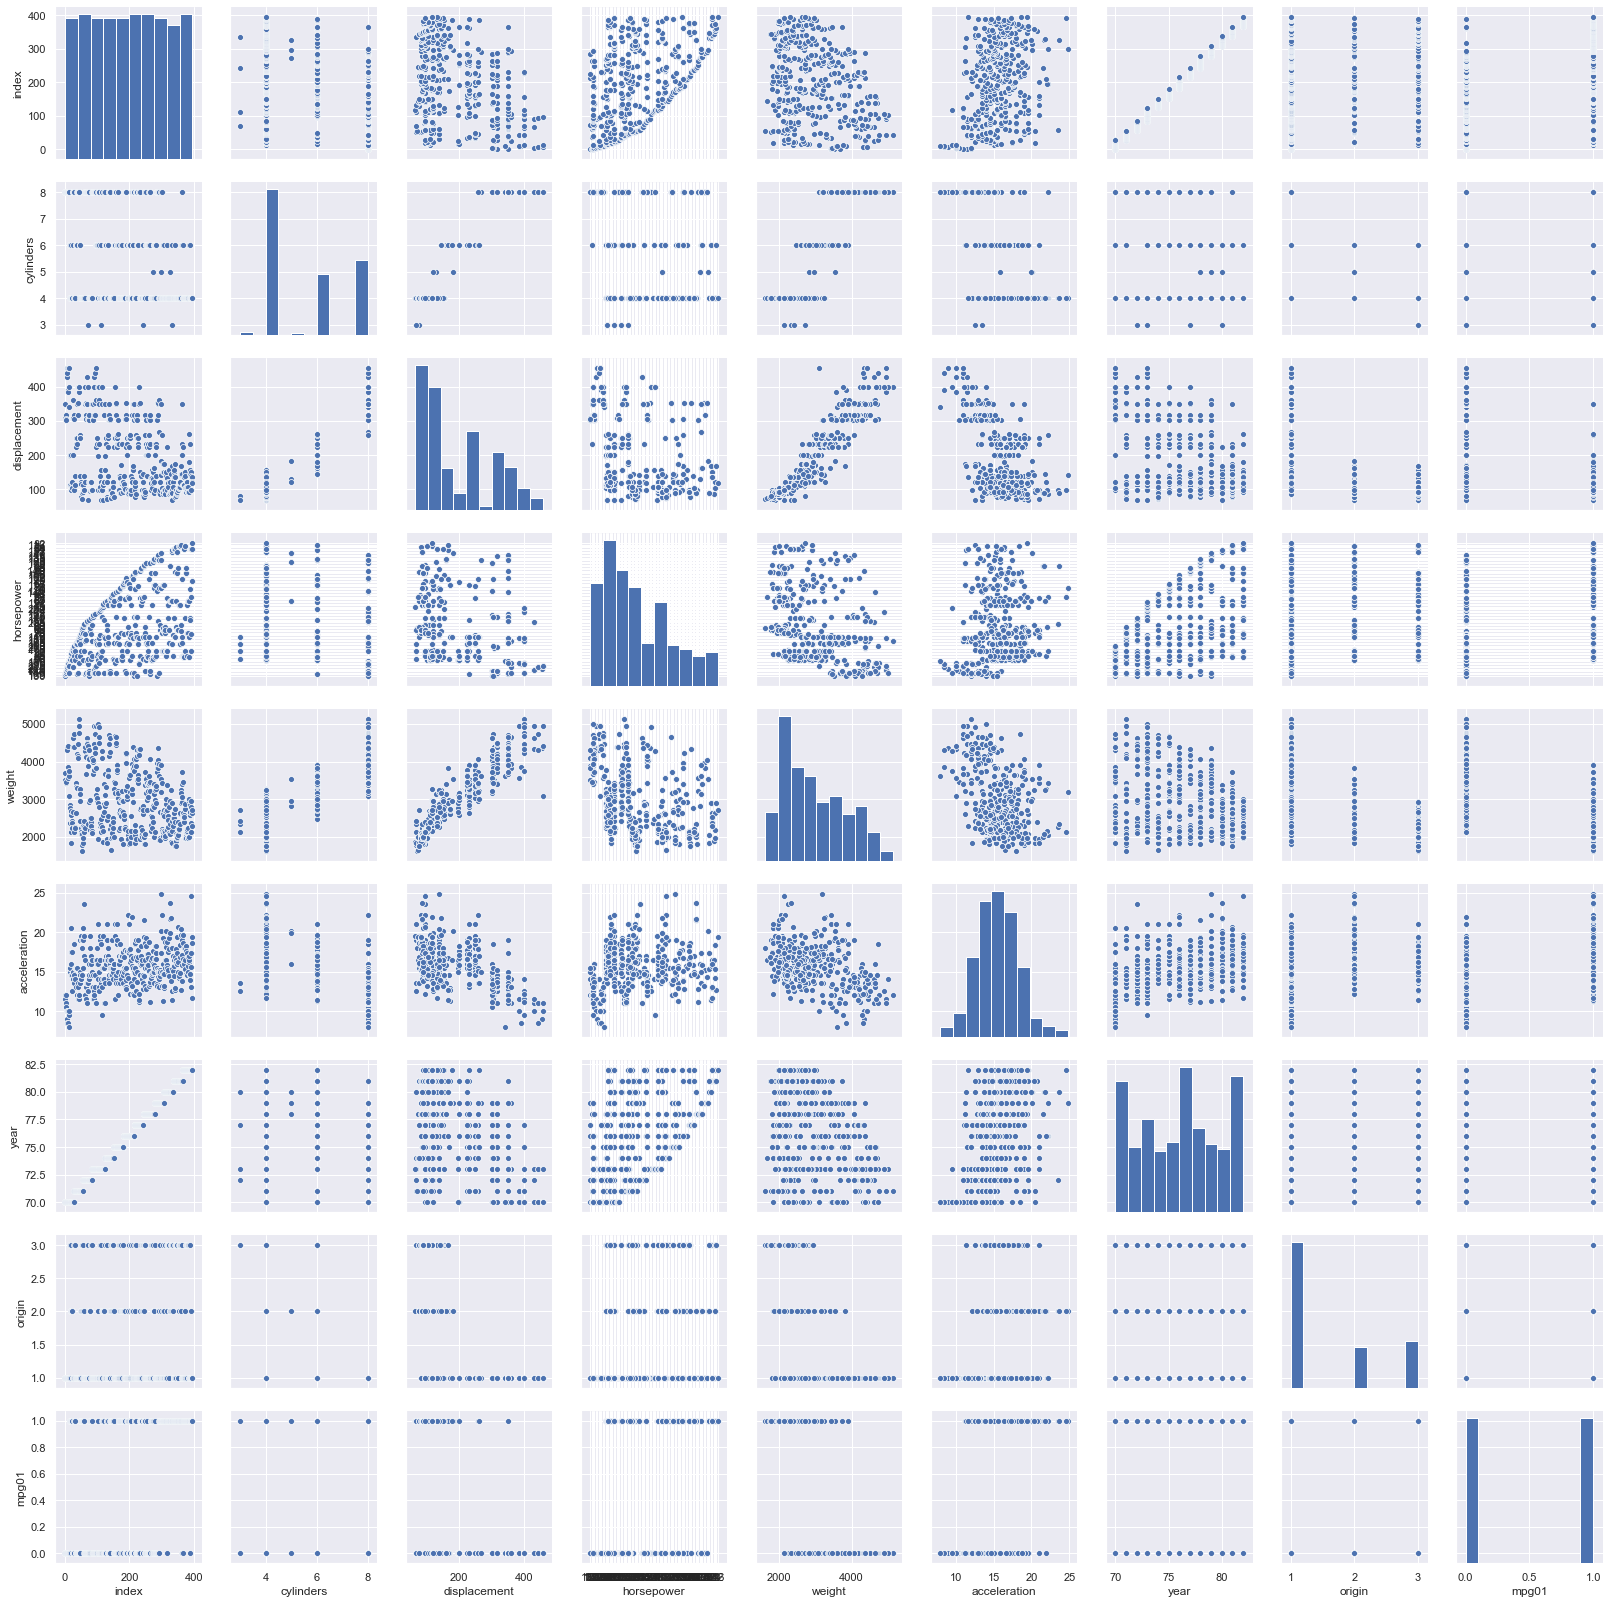

In [298]:
sns.pairplot(auto)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

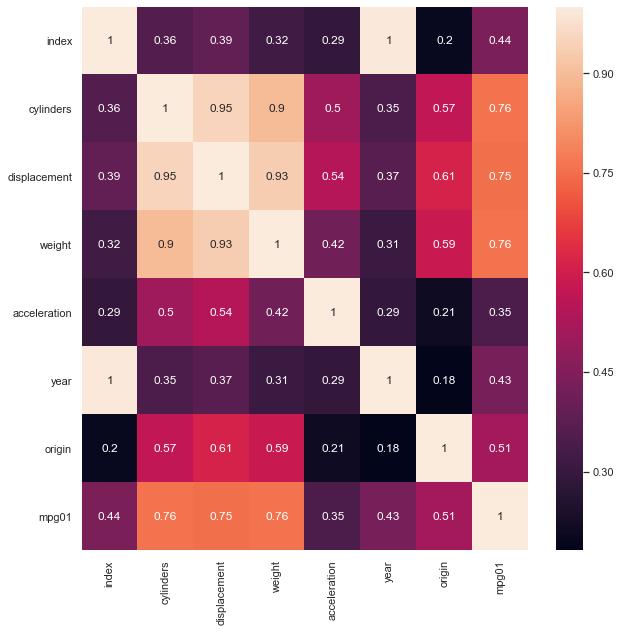

In [315]:
plt.figure(figsize=(10,10))
sns.heatmap(auto.corr().abs(),annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

Weight, displacement and cyclinders look like the most predictive features

**(c) Split the data into a training set and a test set.**

In [324]:
X =  auto.drop(['name'],axis=1)
y = auto['mpg01']

X_train, X_test, y_train, y_test = train_test_split(    X, y, test_size=0.30, random_state=1)

display(HTML('<h3>Training set</h3>'))
display(X_train.head())

# Test set (30%)
display(HTML('<h3>Test set</h3>'))
display(X_test.head())

,index,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
332,335,4,122.0,88,2500,15.1,80,2,1.0
391,396,4,119.0,82,2720,19.4,82,1,1.0
388,393,4,97.0,52,2130,24.6,82,2,1.0
29,29,4,97.0,88,2130,14.5,71,3,1.0
273,275,6,163.0,125,3140,13.6,78,2,0.0


,index,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
81,82,4,120.0,97,2506,14.5,72,3,1.0
165,167,4,97.0,75,2171,16.0,75,3,1.0
351,356,4,108.0,75,2350,16.8,81,3,1.0
119,120,4,121.0,112,2868,15.5,73,2,0.0
379,384,4,91.0,67,1995,16.2,82,3,1.0


**(d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?**




**(e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?**

**(f) Perform logistic regression on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?**

In [351]:
X_train = X_train[['weight','displacement','cylinders']]
X_test  = X_test[['weight','displacement','cylinders']]

# model 
lda = LinearDiscriminantAnalysis().fit(X_train,y_train)
qda = QuadraticDiscriminantAnalysis().fit(X_train,y_train)
logit = LogisticRegression().fit(X_train,y_train)

models = {'logit':logit,
         'lda': lda,
         'qda':qda}

for m in models:
    y_pred = models[m].predict(X_test)
    display(HTML('<h3>{}</h3>'.format(m)))
    display(confusion_table(confusion_matrix(y_test,y_pred)))
    display(model_stats(confusion_matrix(y_test,y_pred)))
   



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,y_pred=0,y_pred=1,Total
,,,
y=0,58,7,65
y=1,2,51,53
Total,60,58,


Prior error rate                    0.550847
total_error_rate                    0.076271
true_positive_rate                  0.962264
false_negative_rate                 0.037736
false_positive_rate                 0.107692
true_negative_rate (specificity)    0.892308
Precision                           0.879310
negative_predictive_value           0.966667
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,58,7,65
y=1,3,50,53
Total,61,57,


Prior error rate                    0.550847
total_error_rate                    0.084746
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.107692
true_negative_rate (specificity)    0.892308
Precision                           0.877193
negative_predictive_value           0.950820
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,61,4,65
y=1,4,49,53
Total,65,53,


Prior error rate                    0.550847
total_error_rate                    0.067797
true_positive_rate                  0.924528
false_negative_rate                 0.075472
false_positive_rate                 0.061538
true_negative_rate (specificity)    0.938462
Precision                           0.924528
negative_predictive_value           0.938462
dtype: float64

**Comment**

After some experimentation with features, I achieved the lowest total error rates with with 'weight', 'cylinders', 'year', 'acceleration'.

Without acceleration linear models were superior. Adding acceleration had no effect on linear models but improved qda suggesting that the addition of acceleration adds a non-linear relationship which linear models are unable to represent.

The QDA result can be achieved with LDA by taking log of predictors.**

**(g) Perform KNN on the training data, with several values of K, in order to predict mpg01. Use only the variables that seemed most associated with mpg01 in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?**

,y_pred=0,y_pred=1,Total
,,,
y=0,55,10,65
y=1,8,45,53
Total,63,55,


Prior error rate                    0.550847
total_error_rate                    0.152542
true_positive_rate                  0.849057
false_negative_rate                 0.150943
false_positive_rate                 0.153846
true_negative_rate (specificity)    0.846154
Precision                           0.818182
negative_predictive_value           0.873016
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,60,5,65
y=1,9,44,53
Total,69,49,


Prior error rate                    0.550847
total_error_rate                    0.118644
true_positive_rate                  0.830189
false_negative_rate                 0.169811
false_positive_rate                 0.076923
true_negative_rate (specificity)    0.923077
Precision                           0.897959
negative_predictive_value           0.869565
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,57,8,65
y=1,8,45,53
Total,65,53,


Prior error rate                    0.550847
total_error_rate                    0.135593
true_positive_rate                  0.849057
false_negative_rate                 0.150943
false_positive_rate                 0.123077
true_negative_rate (specificity)    0.876923
Precision                           0.849057
negative_predictive_value           0.876923
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,60,5,65
y=1,9,44,53
Total,69,49,


Prior error rate                    0.550847
total_error_rate                    0.118644
true_positive_rate                  0.830189
false_negative_rate                 0.169811
false_positive_rate                 0.076923
true_negative_rate (specificity)    0.923077
Precision                           0.897959
negative_predictive_value           0.869565
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,54,11,65
y=1,6,47,53
Total,60,58,


Prior error rate                    0.550847
total_error_rate                    0.144068
true_positive_rate                  0.886792
false_negative_rate                 0.113208
false_positive_rate                 0.169231
true_negative_rate (specificity)    0.830769
Precision                           0.810345
negative_predictive_value           0.900000
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,59,6,65
y=1,7,46,53
Total,66,52,


Prior error rate                    0.550847
total_error_rate                    0.110169
true_positive_rate                  0.867925
false_negative_rate                 0.132075
false_positive_rate                 0.092308
true_negative_rate (specificity)    0.907692
Precision                           0.884615
negative_predictive_value           0.893939
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,56,9,65
y=1,4,49,53
Total,60,58,


Prior error rate                    0.550847
total_error_rate                    0.110169
true_positive_rate                  0.924528
false_negative_rate                 0.075472
false_positive_rate                 0.138462
true_negative_rate (specificity)    0.861538
Precision                           0.844828
negative_predictive_value           0.933333
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,59,6,65
y=1,4,49,53
Total,63,55,


Prior error rate                    0.550847
total_error_rate                    0.084746
true_positive_rate                  0.924528
false_negative_rate                 0.075472
false_positive_rate                 0.092308
true_negative_rate (specificity)    0.907692
Precision                           0.890909
negative_predictive_value           0.936508
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,54,11,65
y=1,3,50,53
Total,57,61,


Prior error rate                    0.550847
total_error_rate                    0.118644
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.169231
true_negative_rate (specificity)    0.830769
Precision                           0.819672
negative_predictive_value           0.947368
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,56,9,65
y=1,3,50,53
Total,59,59,


Prior error rate                    0.550847
total_error_rate                    0.101695
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.138462
true_negative_rate (specificity)    0.861538
Precision                           0.847458
negative_predictive_value           0.949153
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,53,12,65
y=1,3,50,53
Total,56,62,


Prior error rate                    0.550847
total_error_rate                    0.127119
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.184615
true_negative_rate (specificity)    0.815385
Precision                           0.806452
negative_predictive_value           0.946429
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,56,9,65
y=1,3,50,53
Total,59,59,


Prior error rate                    0.550847
total_error_rate                    0.101695
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.138462
true_negative_rate (specificity)    0.861538
Precision                           0.847458
negative_predictive_value           0.949153
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,53,12,65
y=1,3,50,53
Total,56,62,


Prior error rate                    0.550847
total_error_rate                    0.127119
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.184615
true_negative_rate (specificity)    0.815385
Precision                           0.806452
negative_predictive_value           0.946429
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,54,11,65
y=1,3,50,53
Total,57,61,


Prior error rate                    0.550847
total_error_rate                    0.118644
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.169231
true_negative_rate (specificity)    0.830769
Precision                           0.819672
negative_predictive_value           0.947368
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,53,12,65
y=1,3,50,53
Total,56,62,


Prior error rate                    0.550847
total_error_rate                    0.127119
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.184615
true_negative_rate (specificity)    0.815385
Precision                           0.806452
negative_predictive_value           0.946429
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,54,11,65
y=1,3,50,53
Total,57,61,


Prior error rate                    0.550847
total_error_rate                    0.118644
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.169231
true_negative_rate (specificity)    0.830769
Precision                           0.819672
negative_predictive_value           0.947368
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,53,12,65
y=1,3,50,53
Total,56,62,


Prior error rate                    0.550847
total_error_rate                    0.127119
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.184615
true_negative_rate (specificity)    0.815385
Precision                           0.806452
negative_predictive_value           0.946429
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,56,9,65
y=1,3,50,53
Total,59,59,


Prior error rate                    0.550847
total_error_rate                    0.101695
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.138462
true_negative_rate (specificity)    0.861538
Precision                           0.847458
negative_predictive_value           0.949153
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,54,11,65
y=1,3,50,53
Total,57,61,


Prior error rate                    0.550847
total_error_rate                    0.118644
true_positive_rate                  0.943396
false_negative_rate                 0.056604
false_positive_rate                 0.169231
true_negative_rate (specificity)    0.830769
Precision                           0.819672
negative_predictive_value           0.947368
dtype: float64

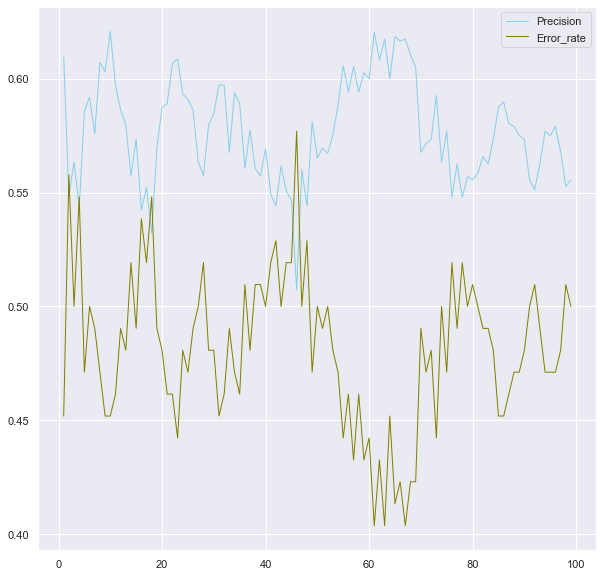

In [363]:
results = []
for k in range(1,20):
    kNN = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    y_pred = kNN.predict(X_test)
    results += [[k,precision(confusion_matrix(y_test,y_pred)),total_error_rate(confusion_matrix(y_test,y_pred))]]
    display(HTML('<h3> KNN - {} </h3>'.format(k)))
    display(confusion_table(confusion_matrix(y_test,y_pred)))
    display(model_stats(confusion_matrix(y_test,y_pred)))

elbow = pd.DataFrame({'k':np.array(elbow)[:,0],'Precision': np.array(elbow)[:,1],
                     'Error_rate':np.array(elbow)[:,2]})
plt.figure(figsize=(10,10))
plt.plot( 'k', 'Precision', data=elbow,  color='skyblue', linewidth=1)
plt.plot( 'k', 'Error_rate', data=elbow, marker='', color='olive', linewidth=1)
plt.legend()

### 12. This problem involves writing functions.

**(a) Write a function, Power(), that prints out the result of raising 2 to the 3rd power. In other words, your function should compute 23 and print out the results**

In [364]:
def Power(num,power):
    return pow(num,power)

**(e) Now using the Power3() function, create a plot of $f(x)=x^2$. The x-axis should display a range of integers from 1 to 10, and the y-axis should display x2. Label the axes appropriately, and use an appropriate title for the figure. Consider displaying either the x-axis, the y-axis, or both on the log-scale. You can do this by using log=‘‘x’’, log=‘‘y’’, or log=‘‘xy’’ as arguments to the plot() function**

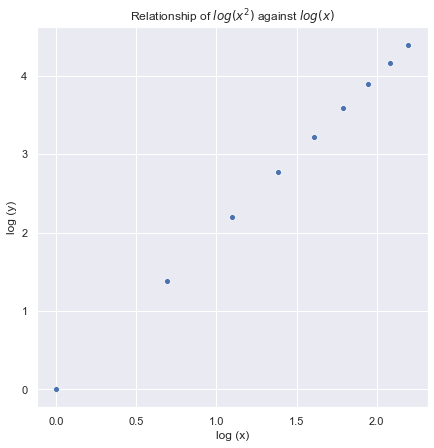

In [377]:
x= np.arange(1,10)
y = Power(x,2)
plt.figure(figsize=(7,7))
sns.scatterplot(x=np.log(x),y=np.log(y))
plt.xlabel("log (x)")
plt.ylabel("log (y)")
plt.title('Relationship of $log(x^2)$ against $log(x)$')
plt.show()

**(f) Create a function, PlotPower(), that allows you to create a plot of x against x^a for a fixed a and for a range of values of x. For instance, if you call**

    PlotPower (1:10 ,3)
    
**then a plot should be created with an x-axis taking on values 1,2,...,10, and a y-axis taking on values 13,23,...,103.**

In [391]:
def PlotPower(start,stop,power):
    x = np.arange(start,stop+1)
    y = Power(x,power)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=x,y=y)
    plt.title('Relationship of $x^{}$ against $x$'.format(power))
    plt.xlabel("x")
    plt.ylabel("$y = x^{}$".format(power))
    
def PlotPowerLog(start,stop,power):
    x = np.arange(start,stop+1)
    y = Power(x,power)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=np.log(x),y=np.log(y))
    plt.title('Relationship of $log(x^{})$ against $log(x)$'.format(power))
    plt.xlabel("log(x)")
    plt.ylabel("$y = log(x^{})$".format(power))

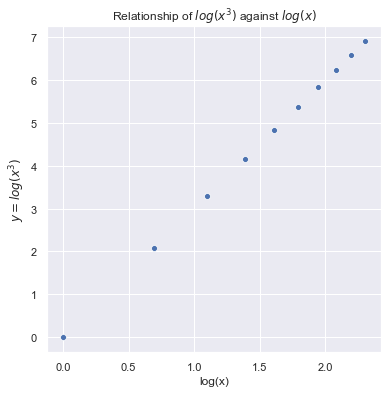

In [392]:
PlotPowerLog(1,10,3)

### 13. Using the Boston data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, and KNN models using various subsets of the predictors. Describe your findings.

In [395]:
boston = datasets.load_boston()

In [439]:
boston_df = pd.DataFrame(boston.data,columns= boston.feature_names)
boston_df

crim01 = (boston_df['CRIM']>boston_df['CRIM'].median()).astype(float).rename('CRIM01')

boston_df = pd.concat([boston_df,crim01],axis=1).drop(['CRIM'],axis=1)
boston_df

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CRIM01
0,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,0.0
1,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,0.0
2,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,0.0
3,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,0.0
4,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,0.0
502,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,0.0
503,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,0.0
504,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,0.0


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]), <a list of 13 Text xticklabel objects>)

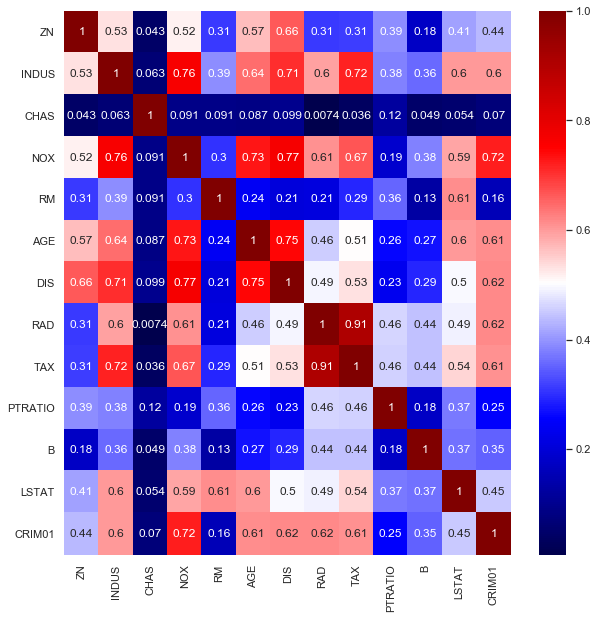

In [442]:
#X_boston = boston_df.drop(['CRIM01'],axis=1)

plt.figure(figsize=(10,10))
sns.heatmap(boston_df.corr().abs(),annot=True,cmap='seismic')
plt.xticks(rotation=90)

In [444]:
X_new = X_boston[['NOX', 'RM', 'DIS', 'RAD', 'LSTAT', 'ZN', 'INDUS', 'PTRATIO']]
X_new

,NOX,RM,DIS,RAD,LSTAT,ZN,INDUS,PTRATIO
0,0.538,6.575,4.0900,1.0,4.98,18.0,2.31,15.3
1,0.469,6.421,4.9671,2.0,9.14,0.0,7.07,17.8
2,0.469,7.185,4.9671,2.0,4.03,0.0,7.07,17.8
3,0.458,6.998,6.0622,3.0,2.94,0.0,2.18,18.7
4,0.458,7.147,6.0622,3.0,5.33,0.0,2.18,18.7
...,...,...,...,...,...,...,...,...
501,0.573,6.593,2.4786,1.0,9.67,0.0,11.93,21.0
502,0.573,6.120,2.2875,1.0,9.08,0.0,11.93,21.0
503,0.573,6.976,2.1675,1.0,5.64,0.0,11.93,21.0
504,0.573,6.794,2.3889,1.0,6.48,0.0,11.93,21.0


In [445]:
y = boston_df['CRIM01']
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [447]:
#models
logit= LogisticRegression().fit(X_train,y_train)
qda = QuadraticDiscriminantAnalysis().fit(X_train,y_train)
lda = LinearDiscriminantAnalysis().fit(X_train,y_train)
models= {'logit':logit,
        'qda':qda,
        'lda':lda}

for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(model_stats(confusion_mtx))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,y_pred=0,y_pred=1,Total
,,,
y=0,74,10,84
y=1,22,61,83
Total,96,71,


Prior error rate                    0.502994
total_error_rate                    0.191617
true_positive_rate                  0.734940
false_negative_rate                 0.265060
false_positive_rate                 0.119048
true_negative_rate (specificity)    0.880952
Precision                           0.859155
negative_predictive_value           0.770833
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,80,4,84
y=1,22,61,83
Total,102,65,


Prior error rate                    0.502994
total_error_rate                    0.155689
true_positive_rate                  0.734940
false_negative_rate                 0.265060
false_positive_rate                 0.047619
true_negative_rate (specificity)    0.952381
Precision                           0.938462
negative_predictive_value           0.784314
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,82,2,84
y=1,26,57,83
Total,108,59,


Prior error rate                    0.502994
total_error_rate                    0.167665
true_positive_rate                  0.686747
false_negative_rate                 0.313253
false_positive_rate                 0.023810
true_negative_rate (specificity)    0.976190
Precision                           0.966102
negative_predictive_value           0.759259
dtype: float64

### Comment

- QDA yields an total error of 3.82%. Far superior to Logistic and LDA. This is not suprising given the non-linear relationships apparent in the pairwise plots above.

- Feature scaling, and log transforms both increased the error rate.

- To achive the above results I started with the 'NOX' feature which appeared strongest in plots, then iteratively tried adding an additional feature – I chose the feature that yielded the greatest reduction in total_error_rate. I repeated this process to choose the next feature and so on.

In [448]:
# PREDICT
for K in range(1, 21):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    
    # Classifier stats
    print('total_error_rate: \n' + str(model_stats(confusion_mtx)['total_error_rate']))

,y_pred=0,y_pred=1,Total
,,,
y=0,79,5,84
y=1,5,78,83
Total,84,83,


total_error_rate: 
0.05988023952095811


,y_pred=0,y_pred=1,Total
,,,
y=0,82,2,84
y=1,9,74,83
Total,91,76,


total_error_rate: 
0.06586826347305386


,y_pred=0,y_pred=1,Total
,,,
y=0,80,4,84
y=1,6,77,83
Total,86,81,


total_error_rate: 
0.05988023952095811


,y_pred=0,y_pred=1,Total
,,,
y=0,83,1,84
y=1,13,70,83
Total,96,71,


total_error_rate: 
0.08383233532934131


,y_pred=0,y_pred=1,Total
,,,
y=0,79,5,84
y=1,8,75,83
Total,87,80,


total_error_rate: 
0.07784431137724546


,y_pred=0,y_pred=1,Total
,,,
y=0,82,2,84
y=1,15,68,83
Total,97,70,


total_error_rate: 
0.10179640718562877


,y_pred=0,y_pred=1,Total
,,,
y=0,78,6,84
y=1,14,69,83
Total,92,75,


total_error_rate: 
0.11976047904191611


,y_pred=0,y_pred=1,Total
,,,
y=0,79,5,84
y=1,18,65,83
Total,97,70,


total_error_rate: 
0.13772455089820357


,y_pred=0,y_pred=1,Total
,,,
y=0,76,8,84
y=1,16,67,83
Total,92,75,


total_error_rate: 
0.14371257485029942


,y_pred=0,y_pred=1,Total
,,,
y=0,77,7,84
y=1,19,64,83
Total,96,71,


total_error_rate: 
0.15568862275449102


,y_pred=0,y_pred=1,Total
,,,
y=0,74,10,84
y=1,17,66,83
Total,91,76,


total_error_rate: 
0.16167664670658688


,y_pred=0,y_pred=1,Total
,,,
y=0,81,3,84
y=1,22,61,83
Total,103,64,


total_error_rate: 
0.14970059880239517


,y_pred=0,y_pred=1,Total
,,,
y=0,77,7,84
y=1,21,62,83
Total,98,69,


total_error_rate: 
0.16766467065868262


,y_pred=0,y_pred=1,Total
,,,
y=0,78,6,84
y=1,22,61,83
Total,100,67,


total_error_rate: 
0.16766467065868262


,y_pred=0,y_pred=1,Total
,,,
y=0,76,8,84
y=1,22,61,83
Total,98,69,


total_error_rate: 
0.17964071856287422


,y_pred=0,y_pred=1,Total
,,,
y=0,81,3,84
y=1,24,59,83
Total,105,62,


total_error_rate: 
0.16167664670658688


,y_pred=0,y_pred=1,Total
,,,
y=0,79,5,84
y=1,24,59,83
Total,103,64,


total_error_rate: 
0.17365269461077848


,y_pred=0,y_pred=1,Total
,,,
y=0,80,4,84
y=1,24,59,83
Total,104,63,


total_error_rate: 
0.16766467065868262


,y_pred=0,y_pred=1,Total
,,,
y=0,80,4,84
y=1,24,59,83
Total,104,63,


total_error_rate: 
0.16766467065868262


,y_pred=0,y_pred=1,Total
,,,
y=0,80,4,84
y=1,25,58,83
Total,105,62,


total_error_rate: 
0.17365269461077848
